# Debt Market Model

$$
\Delta{t} = t_{k+1} - t_{k}\\
{Q}_{k+1} = {Q}_k + v_1 - v_2 - v_3\\
{D_1}_{k+1} = {D_1}_k + u_1 - u_2 - u_3\\
w_3 = u_3 \cdot \frac{w_2}{u_2}\\
w_1 = [(1+\beta_k)^{\Delta{t}}-1]({D_1}_k+{D_2}_k)\\
{D_2}_{k+1} = {D_2}_k + w_1 - w_2 - w_3\\
{R}_{k+1} = {R}_k + w_2\\
$$

<center>
<img src="./diagrams/debt_dynamics.png"
     alt="Debt dynamics"
     style="width: 60%" />
</center>

<center>
<img src="./diagrams/apt_model.png"
     alt="APT model"
     style="width: 60%" />
</center>

## First phase
* Debt market state -> ETH price changes (exogenous) -> exogenous u,v -> endogenous w -> mutates system state

## Second phase
* APT model, arbitragers act -> u,v activity (to remove diversifiable risk) -> results in change to both debt market and secondary market -> stability controller updates redemption rate and price

## Current Model

1. Historically driven ETH price, locks, and draws (eventually to be driven by APT model)
2. Endogenous liquidation and closing of CDPs
3. Debt market state

# Notes

## Resources
* https://github.com/BlockScience/reflexer/blob/next-steps/next_steps.MD
* https://community-development.makerdao.com/en/learn/vaults/liquidation/

* Close CDPs along debt age distribution around 3 months
* How many CDPs are opened daily?
* How are CDPs closed?
* Assumption: opened vs. topped up CDP e.g. ETH price drops, v1 + u1 increase
  * Rate of change of ETH price, make better assumption about new CDP vs top up
  * Break down daily v1/u1 data into multiple CDPs/top ups based on assumption
  * Extreme events -> indicates top up of existing CDP (one that's fallen below certain liquidation ratio)
  
* Large to small CDP liquidation: 50/50 - 2000/1000 at start of 2019
* 1000 to 2000 active CDPs
* 300% average collat ratio

See [Maker network report](https://www.placeholder.vc/blog/2019/3/1/maker-network-report)

> Towards the end of 2018,collateralization   spiked   to   nearly   400%, perhaps  due  to  heightened  risk-aversion  on the  part  of  CDP  holders,but  has  recently declined  back  to  ~270%,  slightly  under  the system’s average of ~300%.

> As  shown  in  Figure  2A, the average non-empty  CDP  declined  from  above $60Kdaiin  debtat  the  start  of  2018  to  just  over $30Kat  the  start  of  2019.Meanwhile,  the medianCDPby debtgrew from under $500in  debtat  the  start  of  the  year,  reaching around $4Kin   August,before   declining sharply to around$500by early February.

> The  significant delta between  mean and  mediandebts highlights thepower  law distribution acrossCDPs. While small CDPs dominate  by number—with  over  80%  of CDPsdrawingless  than $10K  of  dai—they representjust  over 3%  oftotal debt  in  the system.  On  the  other  end  of  the  spectrum, about 90CDPs (less  than  4%by  number) individually have  more  than $100Kin  dai outstanding,  representing nearly  84%  of  all debt  in  the  system.

> Such concentrationin     debtcan     be problematicfor dai supply.For example, four of the six periodsof dai contractiondiscussed in the previous section were associated with CDPs that  had  over$500K  in  debtbeing liquidated. For  example,  CDP  614 hadover 4.3  million in  debt at  liquidation  on  March 18th, accountingfor much of the contraction in outstanding     dai at     the     time. More dramatically,  the  liquidation  of CDPs  3228 and   3164,on   November   20thand   25threspectively,amounted  to  a  contraction  of over $10.7M in dai, making these two CDPs the primary culprits of thelargest contraction in   daisupplyof2018(i.e.   mid-to-late November as showninFigure 1B).

# Imports

In [1]:
from shared import *

In [2]:
import numpy as np
import datetime as dt
import pandas as pd

# Historic MakerDAO Dai debt market activity

In [3]:
debt_market_df = pd.read_csv('market_model/data/debt_market_df.csv', index_col='date', parse_dates=True)
debt_market_df

rho_star   beta         p             Q           v_1  \
date                                                                  
2017-12-18  736.004090  0.005  1.017605  2.425662e+03   2526.662000   
2017-12-19  832.236972  0.005  1.003376  6.240431e+03   3821.320309   
2017-12-20  810.287507  0.005  1.012972  1.418307e+04   8066.895210   
2017-12-21  837.231080  0.005  1.025738  1.564473e+04   1471.742069   
2017-12-22  689.014990  0.005  0.972228  1.883084e+04   5316.960481   
...                ...    ...       ...           ...           ...   
2019-09-26  167.637314  0.125  1.021405  1.525944e+06  56696.770732   
2019-09-27  167.347085  0.125  1.007346  1.529959e+06   7598.158072   
2019-09-28  174.289775  0.125  1.011006  1.528450e+06    876.961579   
2019-09-29  171.054119  0.105  1.013604  1.529013e+06   2263.584945   
2019-09-30  173.096419  0.105  1.007126  1.531726e+06   4436.484054   

               v_2 + v_3           u_1     u_2 + u_3           u_2  \
date                                                                 
2017-12-18    101.000000  5.953420e+05  4.594384e+01  1.000000e+01   
2017-12-19      6.550995  1.379832e+06  3.539448e+04  3.536748e+04   
2017-12-20    124.255903  2.676383e+06  5.022518e+05  5.014128e+05   
2017-12-21     10.080000  8.053550e+05  4.978271e+04  4.978271e+04   
2017-12-22   2130.848985  3.145512e+05  7.474531e+05  7.239153e+05   
...                  ...           ...           ...           ...   
2019-09-26  29566.578527  8.079170e+05  1.585480e+06  1.515115e+06   
2019-09-27   3582.812664  6.087607e+05  6.367461e+05  6.366783e+05   
2019-09-28   2386.452089  2.251956e+05  1.452312e+05  1.452062e+05   
2019-09-29   1700.812508  1.357774e+05  1.699417e+05  1.699335e+05   
2019-09-30   1722.801186  6.848752e+05  1.920650e+05  1.920636e+05   

                     w_2           u_3          w_3     w_2 + w_3  \
date                                                                
2017-12-18      0.000006     35.943840     0.000023      0.000029   
2017-12-19      0.455885     27.000000     0.000348      0.456233   
2017-12-20      0.178879    839.000000     0.000299      0.179179   
2017-12-21      1.158909      0.000000     0.000000      1.158909   
2017-12-22     19.756468  23537.818000     0.642374     20.398842   
...                  ...           ...          ...           ...   
2019-09-26  64257.311824  70364.380268  2984.212338  67241.524162   
2019-09-27   7214.430099     67.790257     0.768156   7215.198255   
2019-09-28    492.589362     25.000000     0.084809    492.674170   
2019-09-29   2581.404125      8.108662     0.123176   2581.527301   
2019-09-30   1250.943840      1.400000     0.009118   1250.952959   

                     D_1           D_2           w_1             D  \
date                                                                 
2017-12-18  5.952961e+05  0.000000e+00      0.000000  5.952961e+05   
2017-12-19  1.939733e+06  2.604943e+01     26.505662  1.939759e+06   
2017-12-20  4.113865e+06  8.208488e+01     56.214632  4.113947e+06   
2017-12-21  4.869437e+06  1.474660e+02     66.539983  4.869584e+06   
2017-12-22  4.436535e+06  1.876926e+02     60.625449  4.436723e+06   
...                  ...           ...           ...           ...   
2019-09-26  7.957442e+07  4.562428e+06  27167.708945  8.413685e+07   
2019-09-27  7.954644e+07  4.582358e+06  27145.743151  8.412880e+07   
2019-09-28  7.962640e+07  4.609044e+06  27177.983765  8.423545e+07   
2019-09-29  7.959224e+07  4.629498e+06  23036.315844  8.422174e+07   
2019-09-30  8.008505e+07  4.651424e+06  23176.738113  8.473647e+07   

                  C_star  p_star  p_ema_10  
date                                        
2017-12-18  1.785297e+06       1  1.008573  
2017-12-19  5.193518e+06       1  1.008573  
2017-12-20  1.149236e+07       1  1.008573  
2017-12-21  1.309826e+07       1  1.008573  
2017-12-22  1.297473e+07       1  1.008573  
...                  ...     ...       ...  
2019-09-26

In [4]:
debt_market_df.insert(0, 'seconds_passed', 24 * 3600)
debt_market_df['cumulative_v_1'] = debt_market_df['v_1'].cumsum()

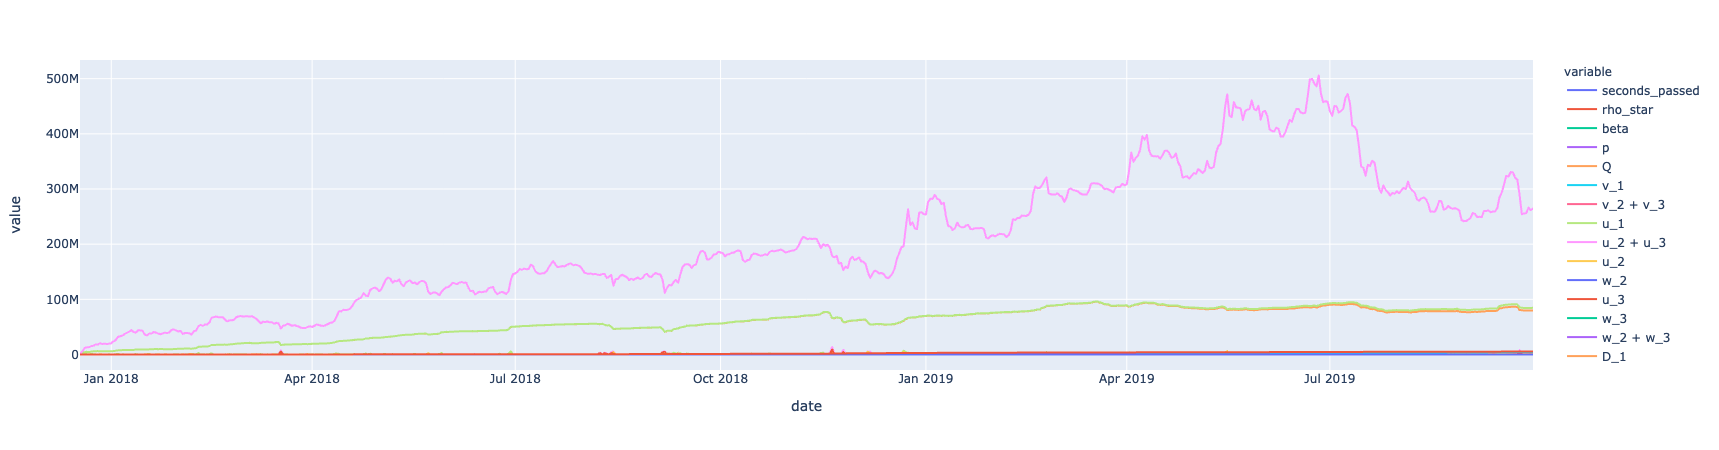

In [5]:
debt_market_df.plot()

# APT Model Setup

In [6]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults
from scipy.misc import derivative
import numpy as np
import seaborn as sns
import pickle

market_price = pd.DataFrame(debt_market_df['p'])
eth_price = pd.DataFrame(debt_market_df['rho_star'])
    
market_returns = np.log(market_price/market_price.shift(1))
eth_returns = np.log(eth_price/eth_price.shift(1)).to_numpy()
    
features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
                'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
                'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
                'D']
            
model = pickle.load(open('./models/apt_model/apt_debt_model.pickle', 'rb'))
independent_vars = debt_market_df[features]
full_prediction = pd.DataFrame(model.predict(independent_vars))

OLSres = OLSResults.load('./models/apt_model/apt_market_model.pickle')

def apt_response(x_name, feature_vals, test_index, p, dp):
    
    # define gradient (central difference)
    def gradient(f, x, dx = 1e-4):
        # convert x dataframe to Series
        y = x.iloc[0]
        n = len(y)
        grad = np.zeros(n)
        for j in range(n):
            dx_i = abs(y[j])*dx if y[j] != 0 else dx
            x_pos = [ x_i if i != j else x_i + dx_i for i, x_i in enumerate(y) ]
            x_neg = [ x_i if i != j else x_i - dx_i for i, x_i in enumerate(y) ]
            # convert back to dataframe for f evaluation
            x_pos = pd.DataFrame(x_pos).T
            x_neg = pd.DataFrame(x_neg).T
            f_pos = f(x_pos)
            f_neg = f(x_neg)
            grad[j] = ( f_pos[0] - f_neg[0] ) / ( 2 * dx_i )
        return grad
    
    # convert price and dp to numpy
    p = p.to_numpy()
    dp = dp.to_numpy()
    
    # get value and gradient at point of interest
    model_value = model.predict(feature_vals)
    model_grad = gradient(model.predict, feature_vals)
    
    # invert gradient (where zero, infinities will appear)
    inv_grad = 1/model_grad
    
    # get index of variable of interest
    feature_index = feature_vals.columns.get_loc(x_name)
    
    # rescale price from regression results
    dp = ( dp - p * OLSres.params[1]*eth_returns[test_index] -
        p * OLSres.resid[test_index] ) / OLSres.params[0]
    
    # zero change for infinities (indicates no change in price for var at this point)
    change = inv_grad[feature_index] if not math.isinf(inv_grad[feature_index]) else 0

    # return change in target variable given observed change in market price 
    dx = ( model_value / p ) * change * dp
    
    return dx
        
def delta_v1(state, state_history):
    t = state['timestep']
    market_price = state['market_price']
    previous_market_price = state_history[-1][-1]['market_price']
    delta_v1 = apt_response('v_1',
                        pd.DataFrame(independent_vars.iloc[t]).T,
                        t,
                        market_price,
                        (market_price - previous_market_price)
    )[0]
    print(delta_v1)
    return delta_v1

FileNotFoundError: [Errno 2] No such file or directory: './models/apt_model/apt_debt_model.pickle'

In [ ]:
def debug_apt_response(t):
    delta_v1 = apt_response('v_1',
                        pd.DataFrame(independent_vars.iloc[t]).T,
                        t,
                        market_price.iloc[t],
                        (market_price.iloc[t] - market_price.iloc[t - 1])
    )[0]
    return delta_v1

# Model Configuration

In [7]:
eth_collateral = 1000.0
eth_price = debt_market_df['rho_star'].iloc[0] #386.71

liquidation_ratio = 1.5 # 150%
liquidation_buffer = 2
collateral_value = eth_collateral * eth_price
target_price = 1.0
principal_debt = collateral_value / (target_price * liquidation_ratio * liquidation_buffer)

print(f'''
{principal_debt * target_price}
{collateral_value}
''')


245334.69675925933
736004.090277778



In [8]:
cdps = pd.DataFrame()
cdps = cdps.append({
    'time': 0,
    'locked': eth_collateral,
    'drawn': principal_debt,
    'wiped': 0.0,
    'freed': 0.0,
    'dripped': 0.0
}, ignore_index=True)
cdps

drawn  dripped  freed  locked  time  wiped
0  245334.696759      0.0    0.0  1000.0   0.0    0.0

In [9]:
initial_state = {
    'events': [],
    'cdps': cdps,
    # Loaded from exogenous parameter
    'eth_price': eth_price, # dollars
    # v
    'eth_collateral': eth_collateral, # Q
    'eth_locked': eth_collateral, # v1
    # u
    'principal_debt': principal_debt, # D1
    'rai_drawn': principal_debt, # u1 "minted"
    # w
    'stability_fee': 0,
    'market_price': target_price,
    'target_price': target_price, # dollars == redemption price
    'target_rate': 0 / (30 * 24 * 3600) # per second interest rate (X% per month)
}

parameters = {
    'free_memory_states': [['cdps', 'events']],
    'eth_market_std': [1],
    'random_state': [np.random.RandomState(seed=0)],
    'liquidation_ratio': [liquidation_ratio], # %
    'liquidation_buffer': [liquidation_buffer], # multiplier applied to CDP collateral by users
    'stability_fee': [lambda timestep, df=debt_market_df: df.iloc[timestep].beta / (365 * 24 * 3600)], # 0.015 / (30 * 24 * 3600), # per second interest rate (1.5% per month)
    'liquidation_penalty': [0], # 0.13 == 13%
    'cdp_top_up_buffer': [2],
    # Average CDP duration == 3 months: https://www.placeholder.vc/blog/2019/3/1/maker-network-report
    # The tuning of this parameter is probably off the average, because we don't have the CDP size distribution matched yet,
    # so although the individual CDPs could have an average debt age of 3 months, the larger CDPs likely had a longer debt age.
    'average_debt_age': [6 * (30 * 24 * 3600)], # delta t (seconds)
    'eth_price': [lambda timestep, df=debt_market_df: df.iloc[timestep].rho_star],
    'delta_v1': [lambda state, _state_history, df=debt_market_df: df.iloc[state['timestep']].v_1], # Driven by historical data
    'delta_u1': [lambda timestep, df=debt_market_df: df.iloc[timestep].u_1], # Driven by historical data
    'seconds_passed': [lambda timestep, df=debt_market_df: df.iloc[timestep].seconds_passed],
    'market_price': [lambda timestep, df=debt_market_df: target_price]
}

# parameters = parameters.update({
#     'delta_v1': [lambda state, state_history: delta_v1(state, state_history)],
#     'market_price': [lambda timestep, df=debt_market_df: df.iloc[timestep].p]
# })

# Simulation Execution

In [10]:
SIMULATION_TIMESTEPS = len(debt_market_df) - 1 # approx. 600
MONTE_CARLO_RUNS = 1

In [11]:
from models.config_wrapper import ConfigWrapper
import models.system_model_v2 as system_model_v2

system_simulation = ConfigWrapper(system_model_v2, T=range(SIMULATION_TIMESTEPS), M=parameters, initial_state=initial_state)

In [12]:
from cadCAD import configs
del configs[:]

system_simulation.append()

(simulation_result, tensor_field, sessions) = run(drop_midsteps=True)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (651, 36, 1, 32)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 151.34s


In [13]:
# Print system events e.g. liquidation assertion errors
simulation_result[simulation_result.events.astype(bool)].events.apply(lambda x: x[0])

651    Liquidation short of collateral: 161.151989870...
Name: events, dtype: object

# Simulation Analysis

In [14]:
simulation_result = pd.concat([simulation_result, debt_market_df.reset_index()], axis=1)

simulation_result = simulation_result.assign(eth_collateral_value = simulation_result.eth_collateral * simulation_result.eth_price)
simulation_result['delta_eth_bitten'] = simulation_result['eth_bitten'].diff()

simulation_result['collateralization_ratio'] = (simulation_result.eth_collateral * simulation_result.eth_price) / (simulation_result.principal_debt * simulation_result.target_price)
simulation_result['historical_collateralization_ratio'] = (simulation_result.Q * simulation_result.rho_star) / (simulation_result.D_1 * simulation_result.p)

simulation_result

index                                             events  error_star  \
0        0                                                 []         0.0   
1       12                                               None         0.0   
2       24                                               None         0.0   
3       36                                               None         0.0   
4       48                                               None         0.0   
..     ...                                                ...         ...   
647   7764                                               None         0.0   
648   7776                                               None         0.0   
649   7788                                               None         0.0   
650   7800                                               None         0.0   
651   7812  [Liquidation short of collateral: 161.15198987...         0.0   

     error_hat  old_error_star  old_error_hat  error_star_integral  \
0          0.0             0.0            0.0                  0.0   
1          0.0             0.0            0.0                  0.0   
2          0.0             0.0            0.0                  0.0   
3          0.0             0.0            0.0                  0.0   
4          0.0             0.0            0.0                  0.0   
..         ...             ...            ...                  ...   
647        0.0             0.0            0.0                  0.0   
648        0.0             0.0            0.0                  0.0   
649        0.0             0.0            0.0                  0.0   
650        0.0             0.0            0.0                  0.0   
651        0.0             0.0            0.0                  0.0   

     error_hat_integral  error_star_derivative  error_hat_derivative  ...  \
0                   0.0                    0.0                   0.0  ...   
1                   0.0                    0.0                   0.0  ...   
2                   0.0                    0.0                   0.0  ...   
3                   0.0                    0.0                   0.0  ...   
4                   0.0                    0.0                   0.0  ...   
..                  ...                    ...                   ...  ...   
647                 0.0                    0.0                   0.0  ...   
648                 0.0                    0.0                   0.0  ...   
649                 0.0                    0.0                   0.0  ...   
650                 0.0                    0.0                   0.0  ...   
651                 0.0                    0.0                   0.0  ...   

              w_1             D        C_star  p_star  p_ema_10  \
0        0.000000  5.952961e+05  1.785297e+06       1  1.008573   
1       26.505662  1.939759e+06  5.193518e+06       1  1.008573   
2       56.214632  4.113947e+06  1.149236e+07       1  1.008573   
3       66.539983  4.869584e+06  1.309826e+07       1  1.008573   
4       60.625449  4.436723e+06  1.297473e+07       1  1.008573   
..            ...           ...           ...     ...       ...   
647  27167.708945  8.413685e+07  2.558052e+08       1  1.008076   
648  27145.743151  8.412880e+07  2.560342e+08       1  1.009903   
649  27177.983765  8.423545e+07  2.663932e+08       1  1.011184   
650  23036.315844  8.422174e+07  2.615439e+08       1  1.011546   
651  23176.738113  8.473647e+07  2.651363e+08       1  1.012724   

    cumulative_v_1  eth_collateral_value  delta_eth_bitten  \
0     2.526662e+03          7.360041e+05               NaN   
1     6.347982e+03          8.322370e+05          0.000000   
2     1.441488e+04          3.906656e+06          0.000000   
3     1.588662e+04          1.079041e+07          0.000000   
4     2.120358e+04          9.894226e+06       1168.849752   
..             ...                   ...               ...   
647   5.391844e+06          2.083946e+08          0.000000   
648   5.39944

## Historical ETH price: December 2017 to September 2019

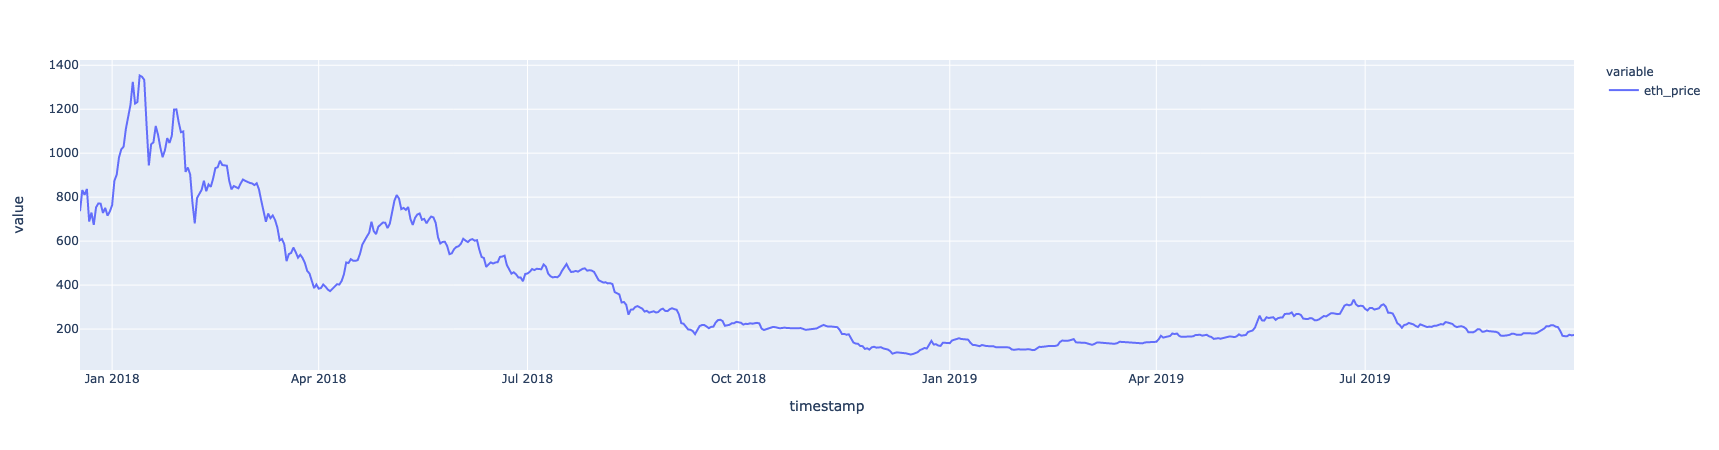

In [15]:
simulation_result.plot(x='timestamp', y=['eth_price'])

## Target price / redemption price set to 1 "dollar" for historical comparison

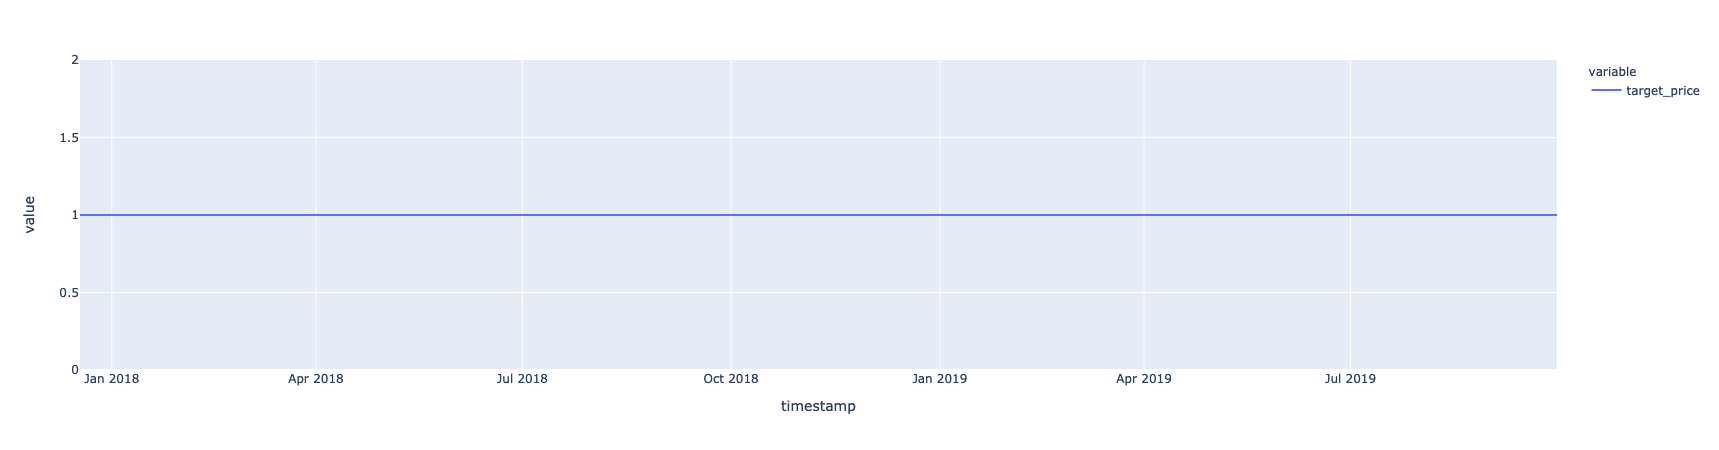

In [16]:
simulation_result.plot(x='timestamp', y=['target_price'])

## Historical system ETH collateral vs. model

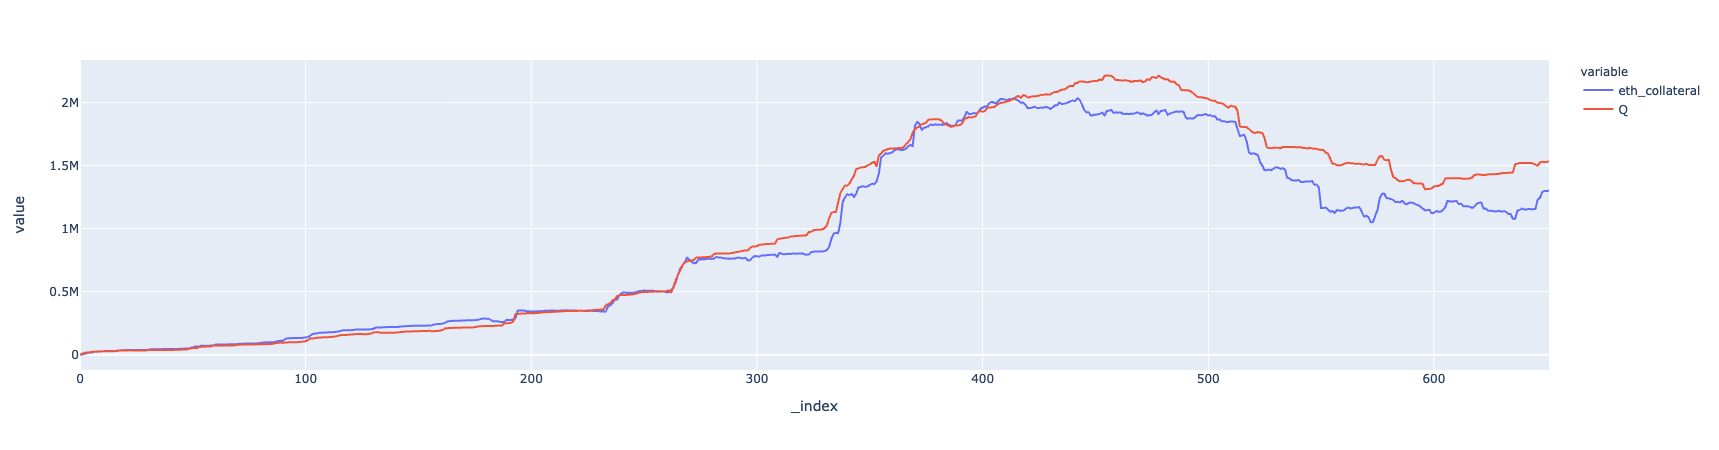

In [17]:
simulation_result.plot(y=['eth_collateral', 'Q'])

## Historical system ETH collateral value vs. model

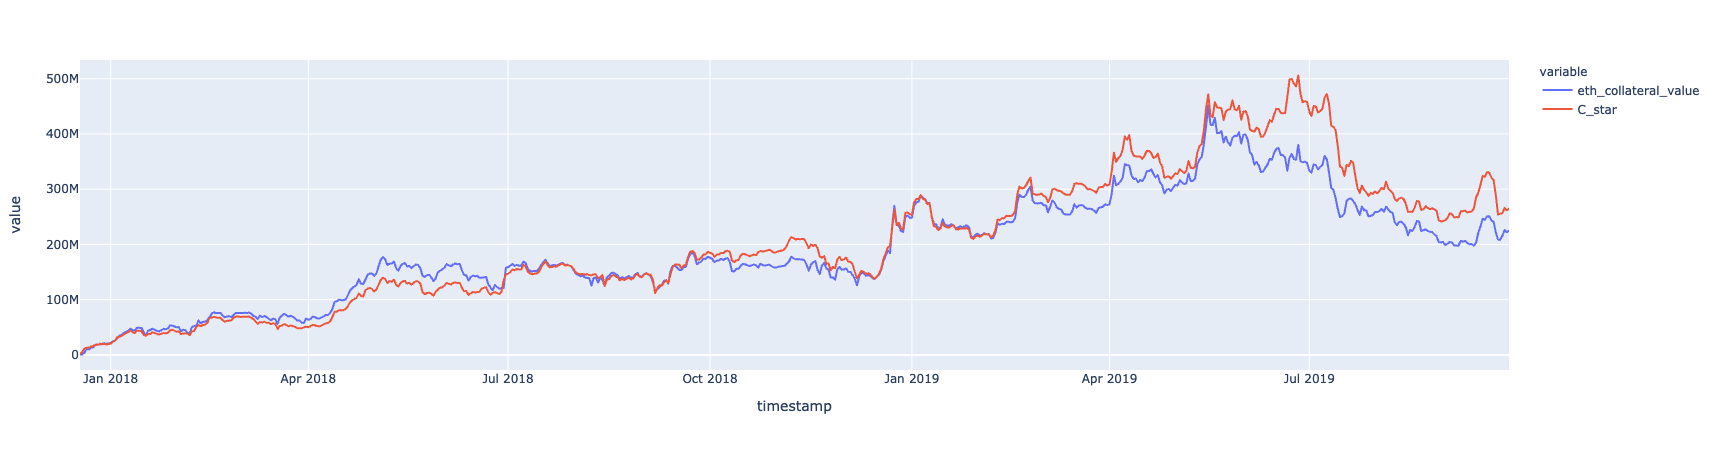

In [18]:
simulation_result.plot(x='timestamp', y=['eth_collateral_value', 'C_star'])

## Debt market ETH activity

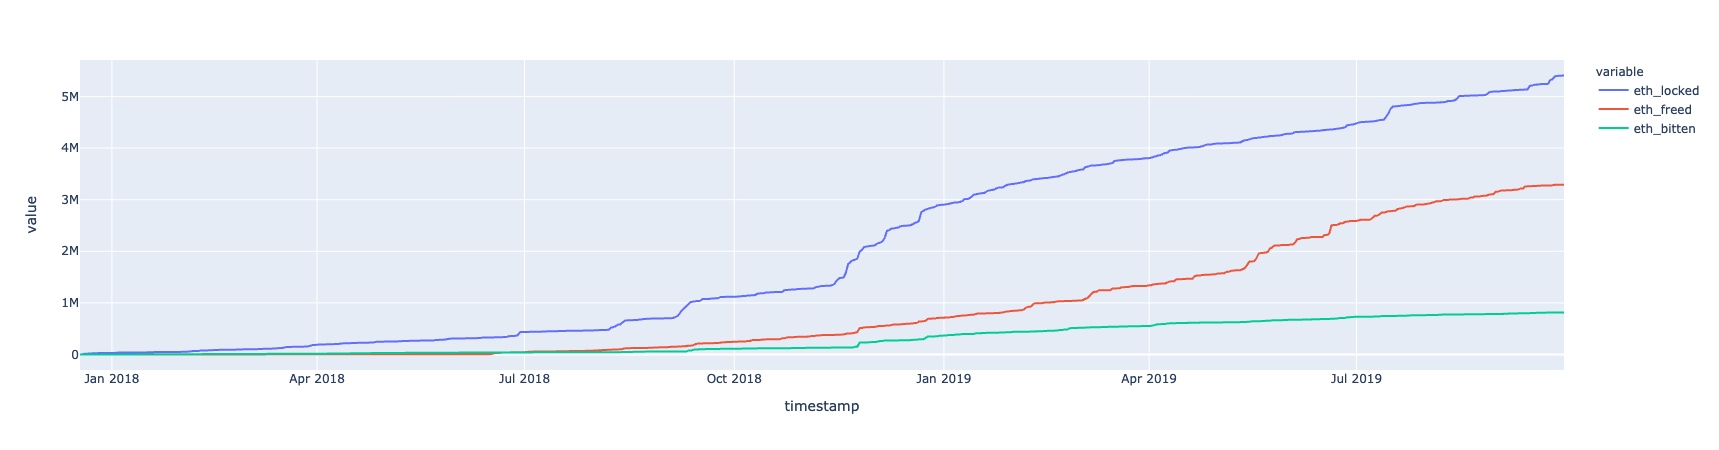

In [19]:
simulation_result.plot(x='timestamp', y=['eth_locked', 'eth_freed', 'eth_bitten'])

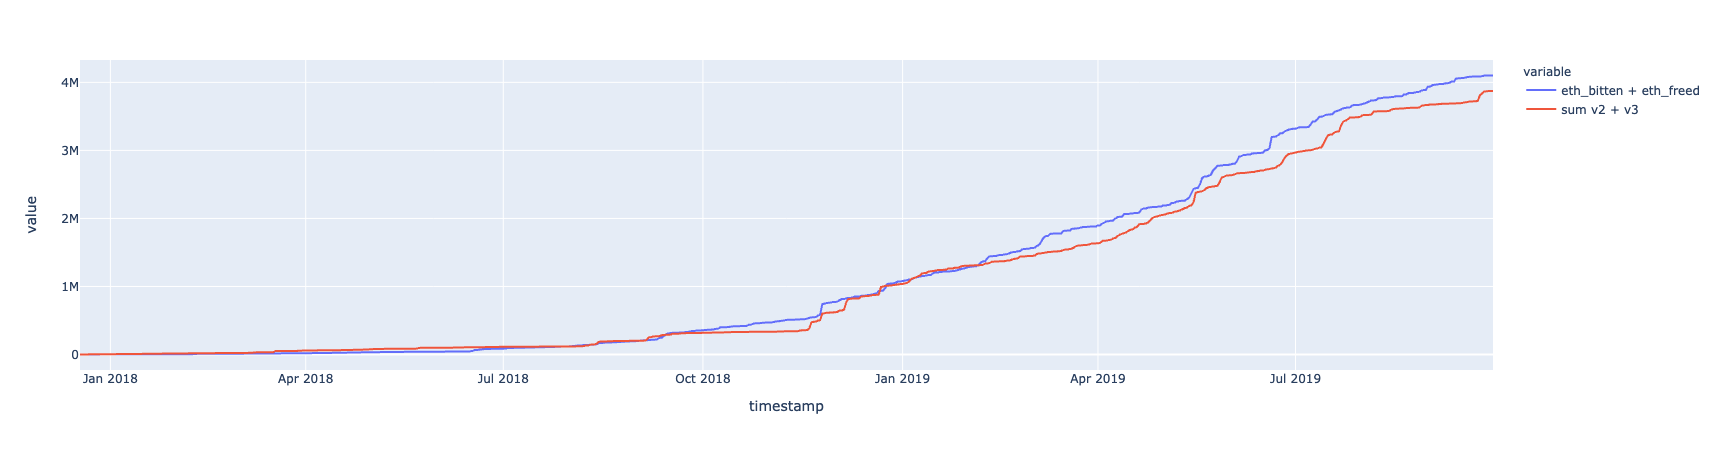

In [20]:
simulation_result['eth_bitten + eth_freed'] = simulation_result['eth_bitten'] + simulation_result['eth_freed']
simulation_result['sum v2 + v3'] = simulation_result['v_2 + v_3'].cumsum()
simulation_result.plot(x='timestamp', y=['eth_bitten + eth_freed', 'sum v2 + v3'])

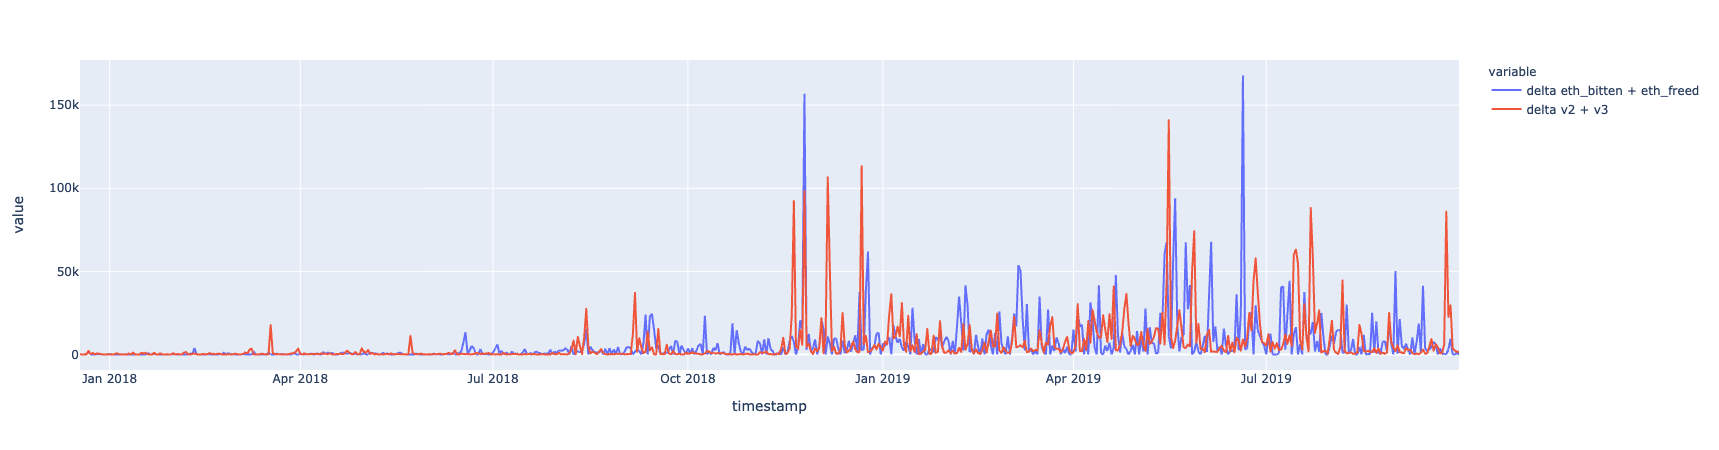

In [21]:
simulation_result['eth_bitten + eth_freed'] = simulation_result['eth_bitten'] + simulation_result['eth_freed']
simulation_result['delta eth_bitten + eth_freed'] = simulation_result['eth_bitten + eth_freed'].diff()
simulation_result['delta v2 + v3'] = simulation_result['v_2 + v_3']
simulation_result.plot(x='timestamp', y=['delta eth_bitten + eth_freed', 'delta v2 + v3'])

## Debt market principal debt "Rai" activity

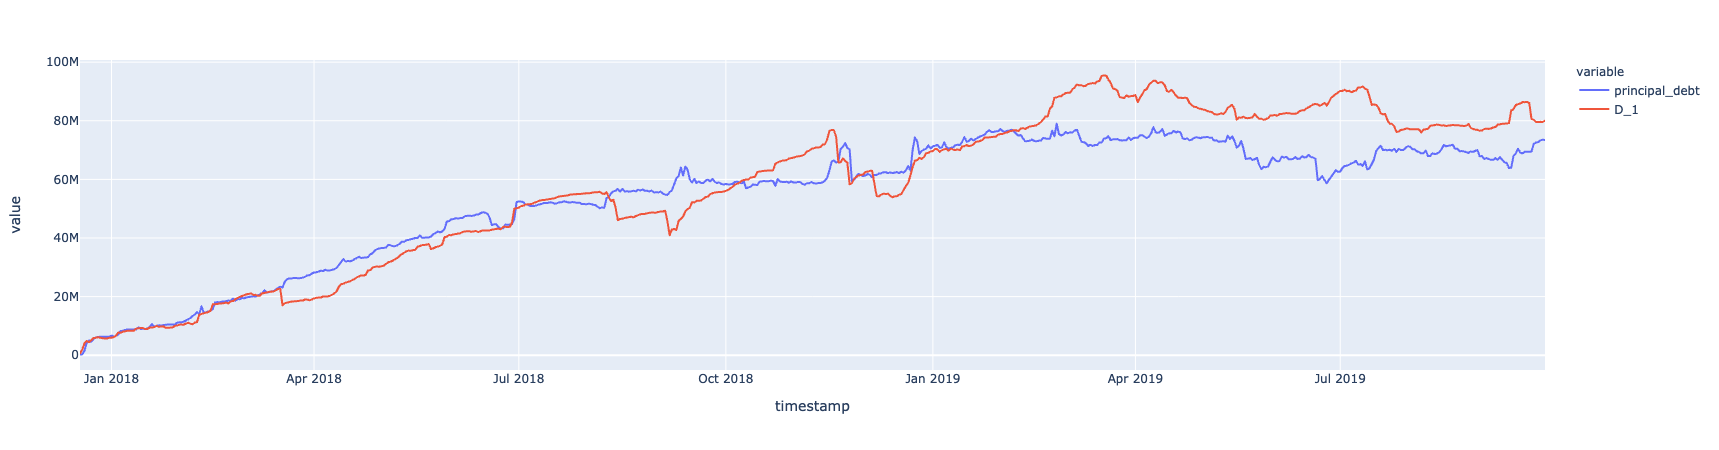

In [22]:
simulation_result.plot(x='timestamp', y=['principal_debt', 'D_1'])

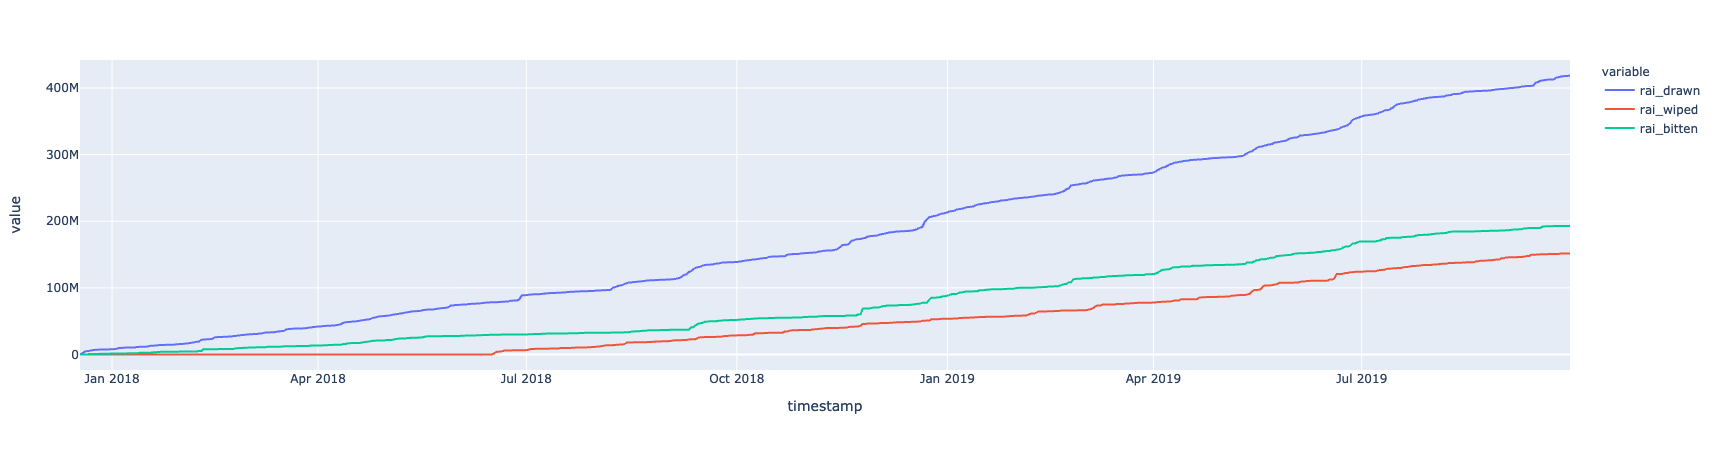

In [23]:
simulation_result.plot(x='timestamp', y=['rai_drawn', 'rai_wiped', 'rai_bitten'])

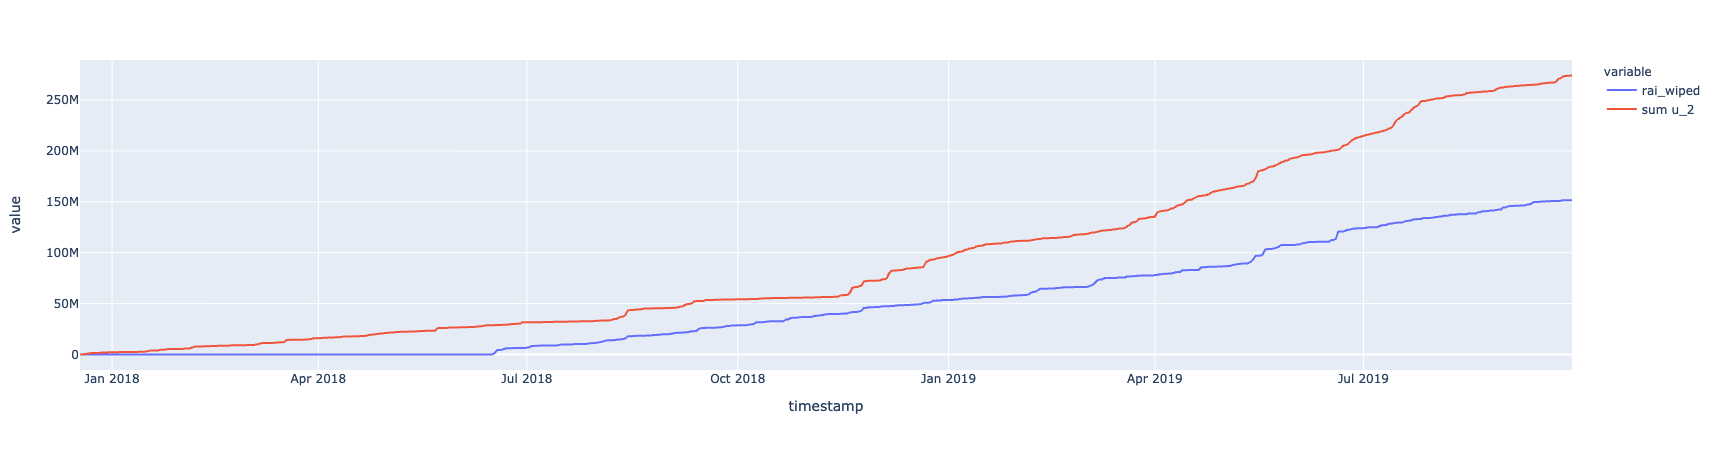

In [24]:
simulation_result['sum u_2'] = simulation_result['u_2'].cumsum()
simulation_result.plot(x='timestamp', y=['rai_wiped', 'sum u_2'])

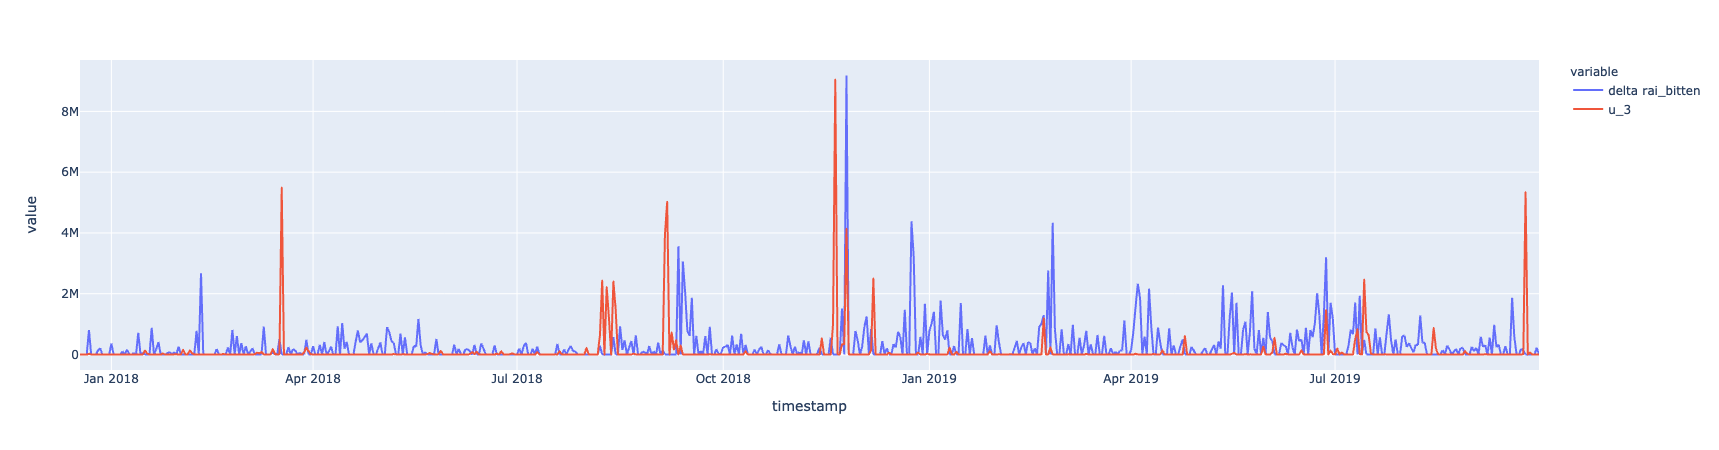

In [25]:
simulation_result['delta rai_bitten'] = simulation_result['rai_bitten'].diff()
simulation_result.plot(x='timestamp', y=['delta rai_bitten', 'u_3'])

## Accrued interest and system revenue (MKR)

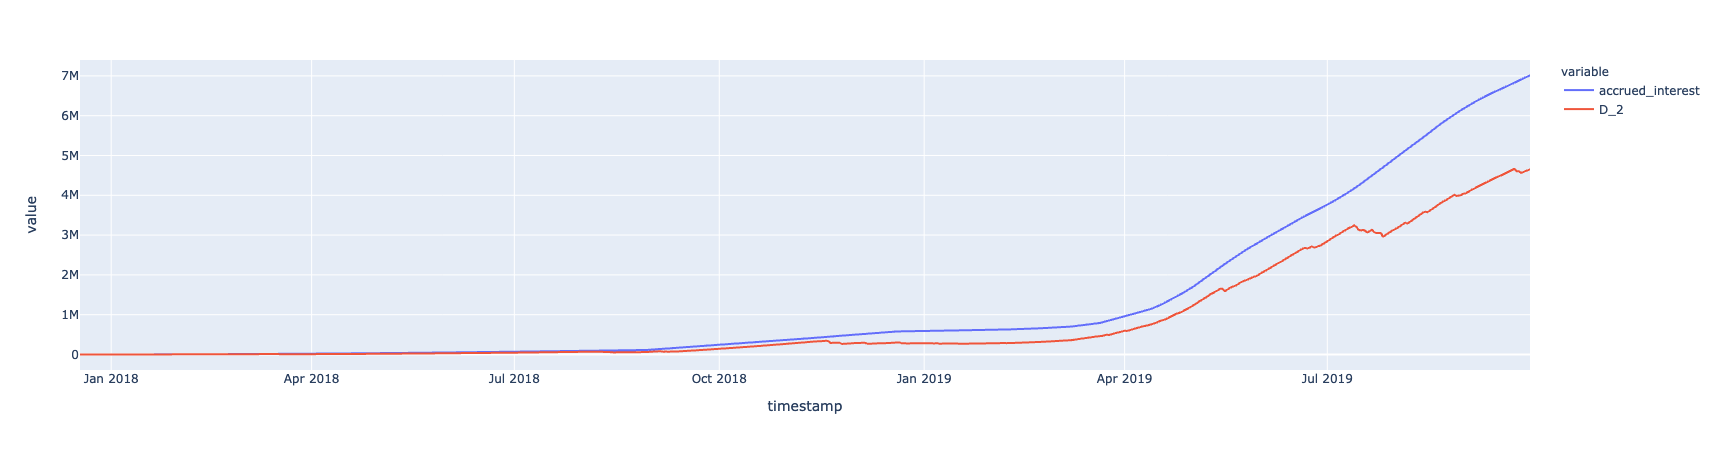

In [26]:
simulation_result.plot(x='timestamp', y=['accrued_interest', 'D_2'])

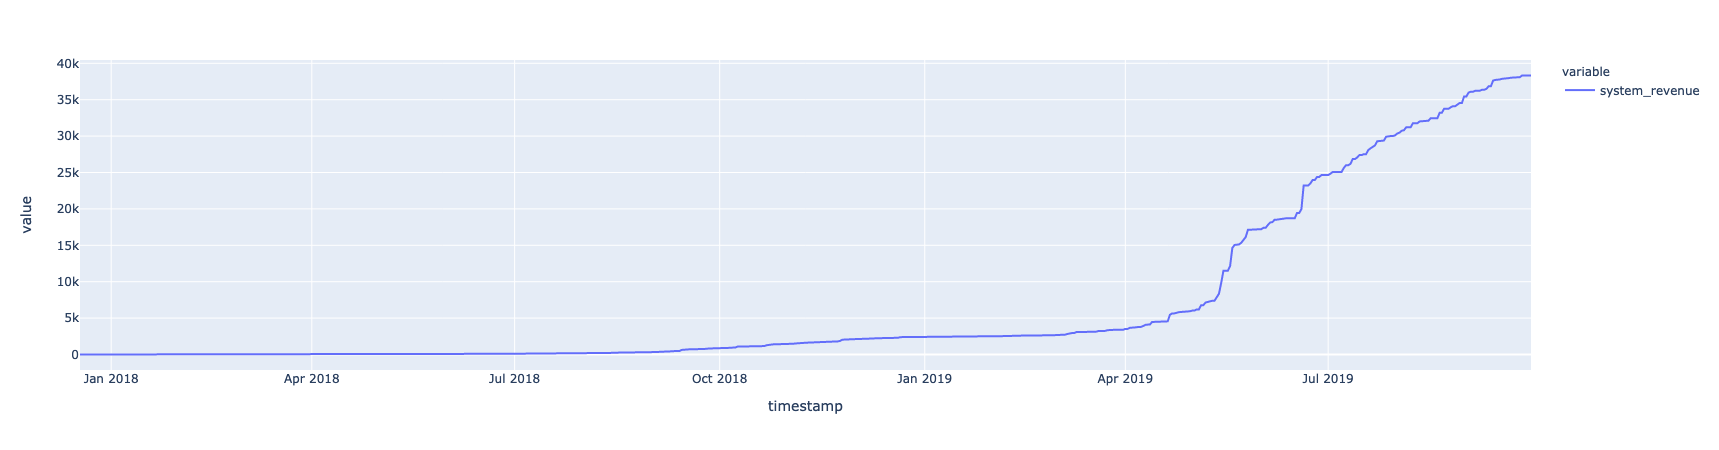

In [27]:
simulation_result.plot(x='timestamp', y=['system_revenue'])

## Historical collateralization ratio vs. model

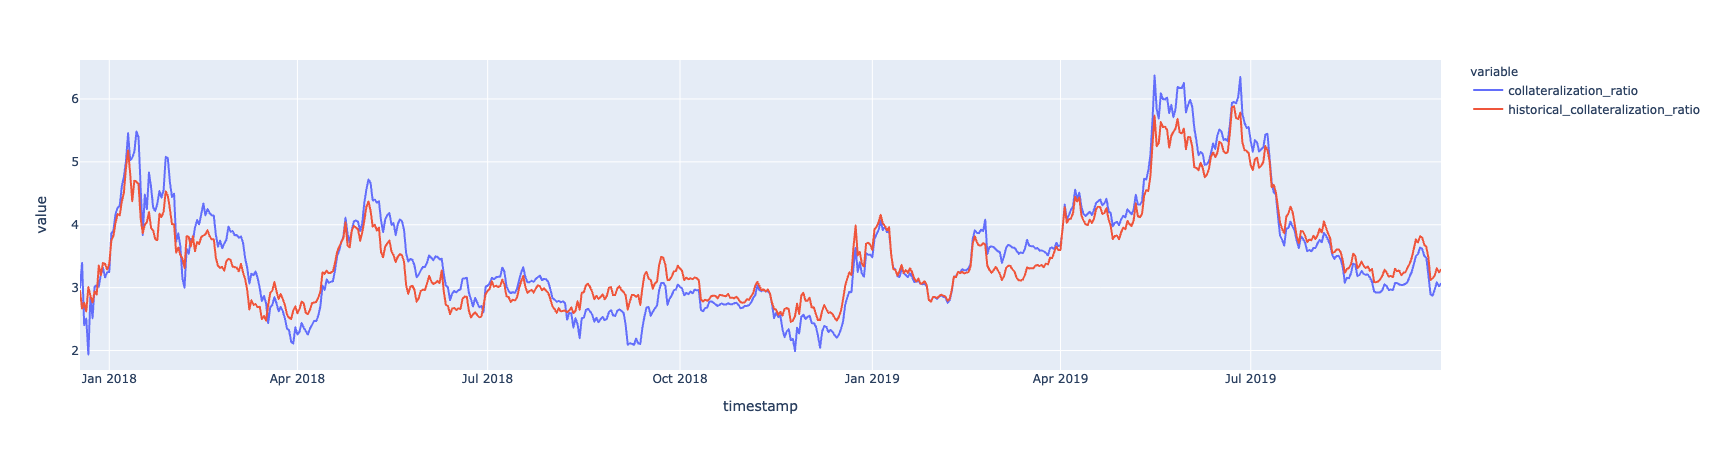

In [28]:
simulation_result.plot(x='timestamp', y=['collateralization_ratio', 'historical_collateralization_ratio'])